In [27]:
import pandas as pd

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/vinaysanga/Tweets-Sentiment-Analysis/master/data.tsv', sep = '\t')


In [29]:
df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [30]:
df.tail()

,sentiment_label,tweet_text
159995,0,STILL @ panera...studying for &quot;mock&quot;...
159996,0,Insomnia is out of control tonight--haven't sl...
159997,4,@Covergirl08 I take pride in what I do
159998,4,heading to work on the 6
159999,4,@queith asi es!


In [31]:
df['sentiment_label'].unique()

array([4, 0])

It appears that 0 is negative sentiment and 4 is a positive sentiment

In [32]:
y = df['sentiment_label']
X = df.drop('sentiment_label', axis = 1)

We start the preprocessing of data now

In [33]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re

# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs, usernames, and special characters
    text = re.sub(r'@ ?\w+', '', text)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'&quot', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d', '', text)

    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a single string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
X['tweet_text'] = X['tweet_text'].apply(preprocess_text)

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from scipy import interp

# Define the number of folds for cross-validation
num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
accuracies_lr = []
precisions_lr = []
recalls_lr = []
f1s_lr = []
tprs_lr = []
aucs_lr = []
mean_fpr_lr = np.linspace(0, 1, 100)

# Convert X and y to numpy arrays
#X = X.values
#y = y.values

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Vectorizing the text data using TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold[:, 0])
    X_test_fold_tfidf = vectorizer.transform(X_test_fold[:, 0])

    # Scale the data
    scaler = MaxAbsScaler()
    X_train_fold_tfidf = scaler.fit_transform(X_train_fold_tfidf)
    X_test_fold_tfidf = scaler.transform(X_test_fold_tfidf)

    # Training a Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_fold_tfidf, y_train_fold)

    # Predicting on the test fold
    y_pred_lr = model.predict(X_test_fold_tfidf)
    y_score_lr = model.predict_proba(X_test_fold_tfidf)[:, 1]

    # Evaluating the model
    fpr, tpr, thresholds = roc_curve(y_test_fold, y_score_lr, pos_label=4)
    tprs_lr.append(interp(mean_fpr_lr, fpr, tpr))
    tprs_lr[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs_lr.append(roc_auc)
    fold_report = classification_report(y_test_fold, y_pred_lr, output_dict=True)
    fold_accuracy = fold_report['accuracy']
    fold_precision =  fold_report['macro avg']['precision']
    fold_recall = fold_report['macro avg']['recall']
    fold_f1 = fold_report['macro avg']['f1-score']

    # Append evaluation metrics to lists
    accuracies_lr.append(fold_accuracy)
    precisions_lr.append(fold_precision)
    recalls_lr.append(fold_recall)
    f1s_lr.append(fold_f1)

<ipython-input-40-bfdfdddb87f3>:52: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs_lr.append(interp(mean_fpr_lr, fpr, tpr))
<ipython-input-40-bfdfdddb87f3>:52: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs_lr.append(interp(mean_fpr_lr, fpr, tpr))
<ipython-input-40-bfdfdddb87f3>:52: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs_lr.append(interp(mean_fpr_lr, fpr, tpr))
<ipython-input-40-bfdfdddb87f3>:52: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs_lr.append(interp(mean_fpr_lr, fpr, tpr))
<ipython-input-40-bfdfdddb87f3>:52: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs_lr.append(interp(mean_fpr_lr, fpr, tpr))


In [44]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV

import re

# Define the number of folds for cross-validation
num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
accuracies_svc = []
f1s_svc = []
precisions_svc = []
recalls_svc = []
tprs_svc = []
aucs_svc = []
mean_fpr_svc = np.linspace(0, 1, 100)

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Vectorizing the text data using TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_fold_tfidf = vectorizer.fit_transform(X_train_fold[:, 0])
    X_test_fold_tfidf = vectorizer.transform(X_test_fold[:, 0])

    # Scale the data
    scaler = MaxAbsScaler()
    X_train_fold_tfidf = scaler.fit_transform(X_train_fold_tfidf)
    X_test_fold_tfidf = scaler.transform(X_test_fold_tfidf)

    # Training a SVC model
    svc = CalibratedClassifierCV(LinearSVC())
    svc.fit(X_train_fold_tfidf, y_train_fold)

    # Predicting on the test set
    y_pred_svc = svc.predict(X_test_fold_tfidf)
    y_score_svc = svc.predict_proba(X_test_fold_tfidf)[:, 1]

    # Evaluating the model
    fpr, tpr, thresholds = roc_curve(y_test_fold, y_score_svc, pos_label=4)
    tprs_svc.append(interp(mean_fpr_lr, fpr, tpr))
    tprs_svc[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs_svc.append(roc_auc)
    fold_report = classification_report(y_test_fold, y_pred_svc, output_dict=True)
    fold_accuracy = fold_report['accuracy']
    fold_precision =  fold_report['macro avg']['precision']
    fold_recall = fold_report['macro avg']['recall']
    fold_f1 = fold_report['macro avg']['f1-score']

    # Append evaluation metrics to lists
    accuracies_svc.append(fold_accuracy)
    precisions_svc.append(fold_precision)
    recalls_svc.append(fold_recall)
    f1s_svc.append(fold_f1)

<ipython-input-44-8525590394ce>:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs_svc.append(interp(mean_fpr_lr, fpr, tpr))
<ipython-input-44-8525590394ce>:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs_svc.append(interp(mean_fpr_lr, fpr, tpr))
<ipython-input-44-8525590394ce>:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs_svc.append(interp(mean_fpr_lr, fpr, tpr))
<ipython-input-44-8525590394ce>:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs_svc.append(interp(mean_fpr_lr, fpr, tpr))
<ipython-input-44-8525590394ce>:50: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs_svc.append(interp(mean_fpr_lr, fpr, tpr))


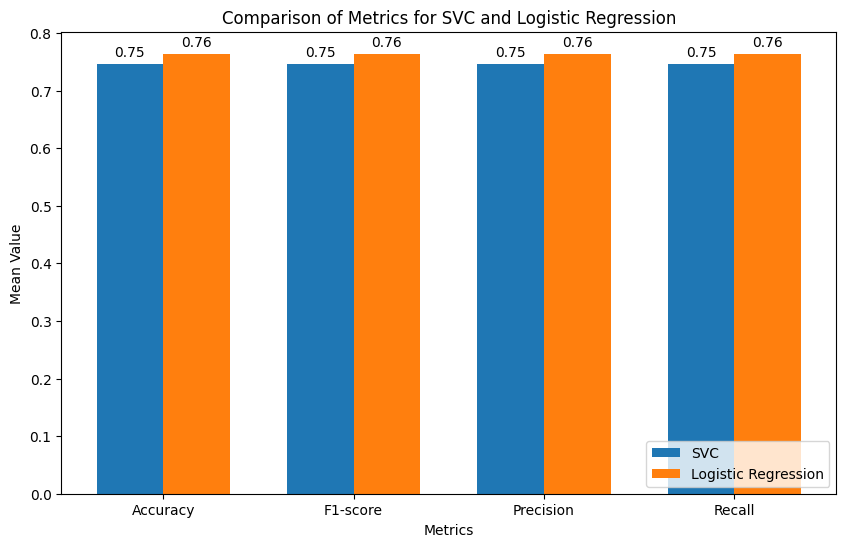

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels for the metrics and models
metrics = ['Accuracy', 'F1-score', 'Precision', 'Recall']
models = ['SVC', 'Logistic Regression']

# Calculate mean values for each metric
mean_accuracy_svc = np.mean(accuracies_svc)
mean_f1_svc = np.mean(f1s_svc)
mean_precision_svc = np.mean(precisions_svc)
mean_recall_svc = np.mean(recalls_svc)

mean_accuracy_lr = np.mean(accuracies_lr)
mean_f1_lr = np.mean(f1s_lr)
mean_precision_lr = np.mean(precisions_lr)
mean_recall_lr = np.mean(recalls_lr)

# Define the mean values for each metric for SVC and Logistic Regression
svc_means = [mean_accuracy_svc, mean_f1_svc, mean_precision_svc, mean_recall_svc]
lr_means = [mean_accuracy_lr, mean_f1_lr, mean_precision_lr, mean_recall_lr]

# Define the position of each bar on X-axis
x = np.arange(len(metrics))

# Define the width of the bars
width = 0.35

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot SVC bars
svc_bars = ax.bar(x - width/2, svc_means, width, label='SVC')

# Plot Logistic Regression bars
lr_bars = ax.bar(x + width/2, lr_means, width, label='Logistic Regression')

# Adding labels, title and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Value')
ax.set_title('Comparison of Metrics for SVC and Logistic Regression')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc='lower right')

# Add values on top of the bars
def autolabel(bars):
    """Attach a text label on top of each bar."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(svc_bars)
autolabel(lr_bars)

# Show plot
plt.show()


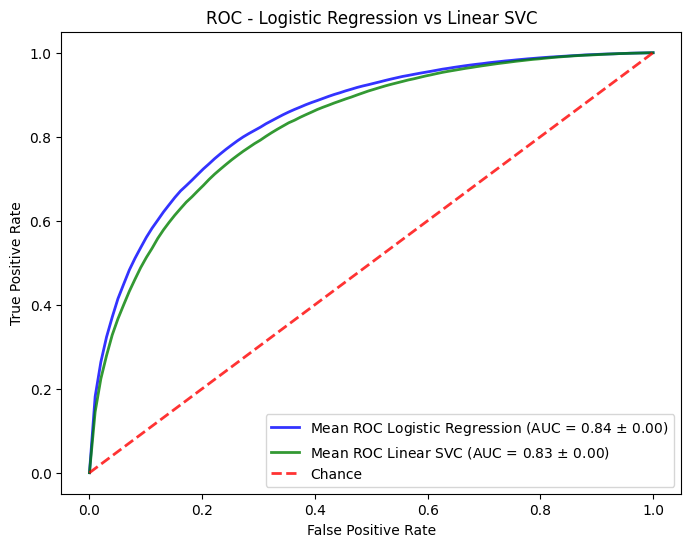

In [46]:
# Calculate mean and standard deviation for TPR for Logistic Regression
mean_tpr_lr = np.mean(tprs_lr, axis=0)
mean_tpr_lr[-1] = 1.0
mean_auc_lr = auc(mean_fpr_lr, mean_tpr_lr)
std_auc_lr = np.std(aucs_lr)

# Calculate mean and standard deviation for TPR for Linear SVC
mean_tpr_svc = np.mean(tprs_svc, axis=0)
mean_tpr_svc[-1] = 1.0
mean_auc_svc = auc(mean_fpr_svc, mean_tpr_svc)
std_auc_svc = np.std(aucs_svc)

# Plotting the ROC curve for Logistic Regression
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr_lr, mean_tpr_lr, color='blue',
         label=r'Mean ROC Logistic Regression (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_lr, std_auc_lr),
         lw=2, alpha=.8)

# Plotting the ROC curve for Linear SVC
plt.plot(mean_fpr_svc, mean_tpr_svc, color='green',
         label=r'Mean ROC Linear SVC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_svc, std_auc_svc),
         lw=2, alpha=.8)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Logistic Regression vs Linear SVC')
plt.legend(loc="lower right")
plt.show()